# Manifold learning with Feature-type distributed clustering workflow is more informative compared to UMAP for tabular clinical datasets

## Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import umap.umap_ as umap
%config InlineBackend.figure_format = 'svg'

In [2]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score

In [3]:
from cluster_val import *

## Importing data

In [4]:
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
data=pd.read_csv('cirrhosis.csv',index_col='ID')

In [5]:
np.random.seed(42)
data=data.sample(frac=1) #Shuffle the data set
np.random.seed(42)
i=[x for x in range(418)]

data.set_index(pd.Series(i), inplace=True)

## Data pre-processing

In [6]:
data.isna().sum()

N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [7]:
data['Status'].value_counts()

C     232
D     161
CL     25
Name: Status, dtype: int64

In [8]:
Status_mod= {'Status': {'C':0,'D':1,'CL':2}}
data.replace(Status_mod,inplace=True)
data['Status']

0      1
1      0
2      0
3      1
4      1
      ..
413    0
414    0
415    0
416    0
417    1
Name: Status, Length: 418, dtype: int64

In [9]:
data['Drug'].value_counts()

D-penicillamine    158
Placebo            154
Name: Drug, dtype: int64

In [10]:
Drug_mod= {'Drug':{'D-penicillamine':0,'Placebo':1}}
data.replace(Drug_mod,inplace=True)
data['Drug']

0      NaN
1      NaN
2      NaN
3      0.0
4      0.0
      ... 
413    1.0
414    1.0
415    1.0
416    NaN
417    1.0
Name: Drug, Length: 418, dtype: float64

In [11]:
data['Sex'].value_counts()

F    374
M     44
Name: Sex, dtype: int64

In [12]:
Sex_mod= {'Sex':{'F':0,'M':1}}
data.replace(Sex_mod,inplace=True)
data['Sex']

0      0
1      0
2      0
3      0
4      1
      ..
413    0
414    0
415    0
416    0
417    0
Name: Sex, Length: 418, dtype: int64

In [13]:
data['Ascites'].value_counts()

N    288
Y     24
Name: Ascites, dtype: int64

In [14]:
Ascites_mod= {'Ascites':{'N':0,'Y':1}}
data.replace(Ascites_mod,inplace=True)
data['Ascites']

0      NaN
1      NaN
2      NaN
3      0.0
4      0.0
      ... 
413    0.0
414    0.0
415    0.0
416    NaN
417    1.0
Name: Ascites, Length: 418, dtype: float64

In [15]:
data['Hepatomegaly'].value_counts()

Y    160
N    152
Name: Hepatomegaly, dtype: int64

In [16]:
Hepatomegaly_mod= {'Hepatomegaly':{'N':0,'Y':1}}
data.replace(Hepatomegaly_mod,inplace=True)
data['Hepatomegaly']

0      NaN
1      NaN
2      NaN
3      1.0
4      0.0
      ... 
413    0.0
414    0.0
415    1.0
416    NaN
417    1.0
Name: Hepatomegaly, Length: 418, dtype: float64

In [17]:
data['Spiders'].value_counts()

N    222
Y     90
Name: Spiders, dtype: int64

In [18]:
Spiders_mod= {'Spiders':{'N':0,'Y':1}}
data.replace(Spiders_mod,inplace=True)
data['Spiders']

0      NaN
1      NaN
2      NaN
3      0.0
4      1.0
      ... 
413    0.0
414    0.0
415    0.0
416    NaN
417    1.0
Name: Spiders, Length: 418, dtype: float64

In [19]:
data['Edema'].value_counts()

N    354
S     44
Y     20
Name: Edema, dtype: int64

In [20]:
Edema_mod= {'Edema':{'N':0,'S':1,'Y':2}}
data.replace(Edema_mod,inplace=True)
data['Edema']

0      0
1      0
2      0
3      1
4      2
      ..
413    0
414    0
415    0
416    0
417    2
Name: Edema, Length: 418, dtype: int64

## Imputing missing values

In [21]:
dense_data_pool=list(data.isna().sum().index[data.isna().sum()<1])
dense_data=data[dense_data_pool]
dense_data=dense_data.dropna()
data=data.loc[np.array(dense_data.index)]

In [22]:
from scipy.spatial import distance
distance_matrix=[]
for i in range(len(np.array(dense_data))):
    dist=[]
    for j in range(len(np.array(dense_data))):
        d=distance.euclidean(np.array(dense_data)[i],np.array(dense_data)[j])
        dist.append(d)
        neb_list=np.array(dense_data.index)[np.argsort(dist)]
    distance_matrix.append(neb_list)
distance_matrix=np.array(distance_matrix)

In [23]:
missing_value_list = [x for x in list(data.columns) if x not in dense_data_pool]

In [24]:
total_impute_master=[]
for f in range(len(missing_value_list)):
    missing_value_indices=data[data[missing_value_list[f]].isnull()].index.tolist()
    feature_impute_master=[]
    for index in missing_value_indices:
        index_in_dist_mat=np.where(distance_matrix[:,0]==index)[0][0]
        value_list=[]
        neb_index_counter=1
        while len(value_list)<6:
            neb_index=distance_matrix[index_in_dist_mat][neb_index_counter]
            neb_index_counter=neb_index_counter+1
            impute_value=data.loc[[neb_index]][missing_value_list[f]]
            if float(impute_value)!=float(impute_value):
                pass
            else:
                value_list.append(float(impute_value))
        feature_impute_master.append(np.array(value_list))
    total_impute_master.append(np.array(feature_impute_master))
total_impute_mater=np.array(total_impute_master)


In [25]:
total_impute=[]
for i in range(len(total_impute_master)):
    feature_impute=[]
    for j in range(len(total_impute_master[i])):
        intcounter=0
        for k in range(len(total_impute_master[i][j])):
            if total_impute_master[i][j][k]-int(total_impute_master[i][j][k])==0:
                intcounter=intcounter+1
        if intcounter==len(total_impute_master[i][j]):
            imputed_value=np.bincount(total_impute_master[i][j].astype(int)).argmax()
        else:
            imputed_value=np.mean(total_impute_master[i][j])
        feature_impute.append(np.array(imputed_value))
    total_impute.append(np.array(feature_impute))
    

In [26]:
for f in range(len(missing_value_list)):
    missing_value_indices=data[data[missing_value_list[f]].isnull()].index.tolist()
    for i in range(len(missing_value_indices)):
        data.at[missing_value_indices[i], missing_value_list[f]]=total_impute[f][i]

In [27]:
data.isna().sum()

N_Days           0
Status           0
Drug             0
Age              0
Sex              0
Ascites          0
Hepatomegaly     0
Spiders          0
Edema            0
Bilirubin        0
Cholesterol      0
Albumin          0
Copper           0
Alk_Phos         0
SGOT             0
Tryglicerides    0
Platelets        0
Prothrombin      0
Stage            0
dtype: int64

In [28]:
data=data.drop(['Stage'], axis=1)


In [29]:
data.shape

(418, 18)

## UMAP on original data

In [30]:
from fdc.fdc import feature_clustering
from fdc.fdc import FDC, Clustering
from fdc.fdc import canberra_modified
from fdc.clustering import *
modified_can = canberra_modified

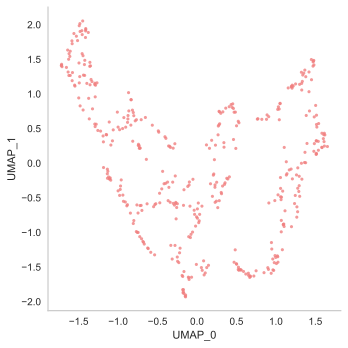

In [31]:
umap_emb=feature_clustering(15,0.1,'euclidean',data,True)

## Silhouette_score  and Dunn index for umap clusters extracted using K-means clustering

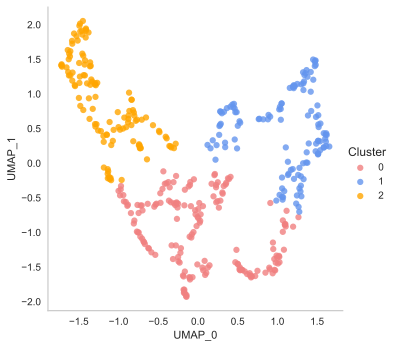

In [32]:
umap_clustering=Clustering(umap_emb,umap_emb,True)
umap_cluster_list,umap_cluster_counts=umap_clustering.K_means(3)

In [33]:
 silhouette_score(umap_emb, umap_cluster_list, metric='euclidean')


0.5888976924815048

## Visualizing Silhouette score (you can also choose the number of clusters based on score)

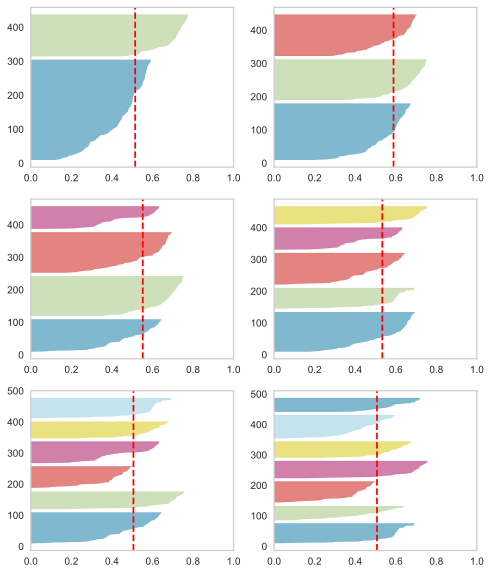

In [34]:
Silhouette_visual(umap_emb)

## Elbow plot for umap_embedding

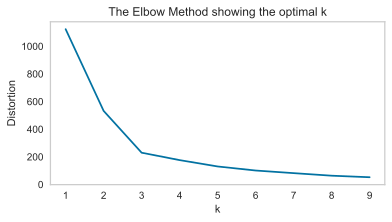

In [35]:
elbow_plot(umap_emb)

In [36]:
dunn_index(cluster_wise_df(umap_emb,umap_cluster_list))

0.0335985368169216

## Silhouette_score  and Dunn index for umap clusters extracted using Agglomerative clustering

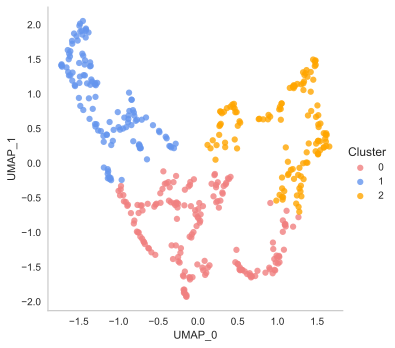

In [37]:
umap_cluster_list_agglo,umap_cluster_counts_agglo=umap_clustering.Agglomerative(3,'euclidean','ward')

In [38]:
silhouette_score(umap_emb, umap_cluster_list_agglo, metric='euclidean')

0.6116712428833995

In [39]:
dunn_index(cluster_wise_df(umap_emb,umap_cluster_list_agglo))

0.03748411896487865

## Silhouette_score  and Dunn index for umap clusters extracted using DBSCAN clustering

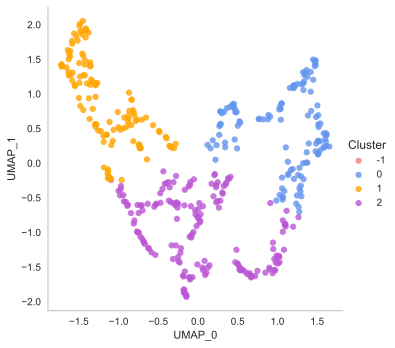

In [40]:
umap_cluster_list_dbscan,umap_cluster_counts_dbscan=umap_clustering.DBSCAN(0.5,20)

In [41]:
#removing noise indices from the embeddings
non_noise_indices= np.where(np.array(umap_cluster_list_dbscan)!=-1)
umap_emb= umap_emb.iloc[non_noise_indices]
#FDC_emb_low= FDC_emb_low.iloc[non_noise_indices]
umap_cluster_list_dbscan= np.array(umap_cluster_list_dbscan)[non_noise_indices]


In [42]:
silhouette_score(umap_emb, umap_cluster_list_dbscan, metric='euclidean')

0.6129026607356839

In [43]:
dunn_index(cluster_wise_df(umap_emb,umap_cluster_list_dbscan))

0.03748411896487865

## Dividing features
- cont_list=continueous features
- ord_list=ordinal features
- nom_list=nominal features



In [44]:
cont_list= ['N_Days','Age','Bilirubin','Cholesterol','Albumin','Copper','Alk_Phos','SGOT','Tryglicerides','Platelets','Prothrombin']

ord_list= ['Ascites','Hepatomegaly','Spiders','Edema']

nom_list= ['Status','Drug','Sex']

In [45]:
len(ord_list)

4

In [46]:
len(nom_list)

3

In [47]:
len(cont_list)

11

## FDC on original data

In [48]:
from fdc.fdc import feature_clustering
from fdc.fdc import FDC, Clustering
from fdc.fdc import canberra_modified
modified_can = canberra_modified

FDC.normalize (init): 0.00000 / 0.000s
FDC.normalize (clustering CONT): 3.03125 / 3.031s
FDC.normalize (clustering ORD): 7.40625 / 10.438s
FDC.normalize (clustering NOM): 6.07812 / 16.516s
FDC.normalize (concat): 0.00000 / 16.516s
FDC.normalize (umap 5 -> 2): 2.29688 / 18.812s
FDC.normalize (array -> DataFrame): 0.00000 / 18.812s


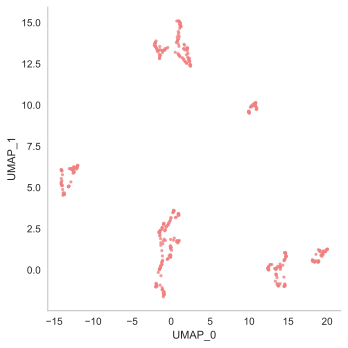

FDC.normalize (plotting): 1.18750 / 20.000s
FDC.normalize (array -> DataFrame): 0.00000 / 20.000s
FDC.normalize (total): 0.00000 / 20.000s


In [49]:

fdc = FDC(clustering_cont=Clustering('euclidean',15,0.1)
          , clustering_ord=Clustering(modified_can,15,0.1)
          , clustering_nom=Clustering('hamming',15,0.1)
          , visual=True
          , use_pandas_output=True
          , with_2d_embedding=True
          )

fdc.selectFeatures(continueous=cont_list, nomial=nom_list, ordinal=ord_list)

FDC_emb_high,FDC_emb_low = fdc.normalize(data,n_neighbors=15, min_dist=0.1,cont_list=cont_list, nom_list=nom_list, ord_list=ord_list,
                  with_2d_embedding=True,
                  visual=True)

## Silhouette_score  and Dunn index for fdc clusters  extracted (intermediate_dim) using K-means clustering

In [50]:
from fdc.clustering import Clustering

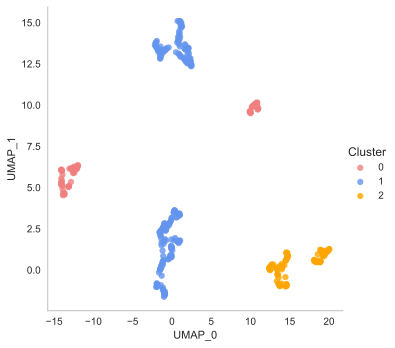

In [51]:
clustering=Clustering(FDC_emb_high,FDC_emb_low,True)
cluster_list,cluster_counts=clustering.K_means(3)

In [52]:
FDC_emb_high['Cluster'] = cluster_list

In [53]:
silhouette_score(FDC_emb_high, cluster_list, metric='euclidean')


0.357517388393725

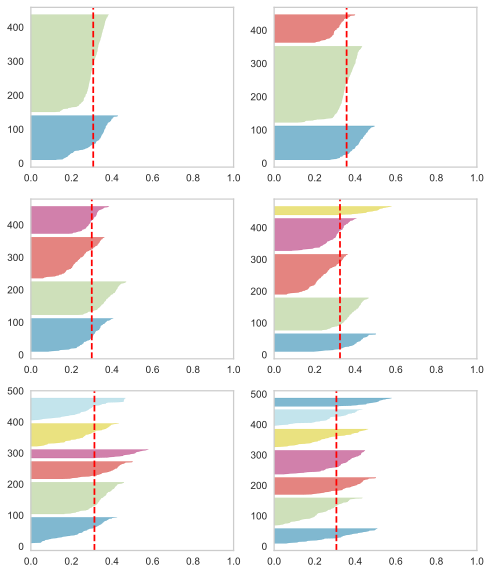

In [54]:
Silhouette_visual(FDC_emb_high)

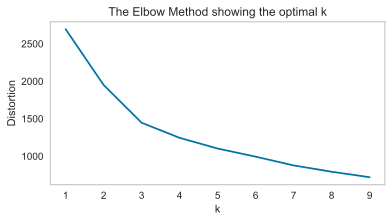

In [55]:
elbow_plot(FDC_emb_high)

In [56]:
dunn_index(cluster_wise_df(FDC_emb_high,cluster_list))

0.44430622569348976

## Silhouette_score  and Dunn index for fdc clusters  extracted (intermediate_dim) using Agglomerative clustering

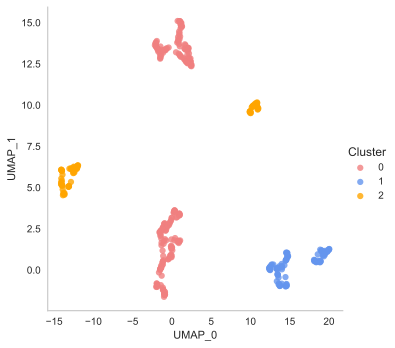

In [57]:
cluster_list_agglo,cluster_counts_agglo=clustering.Agglomerative(3,'euclidean','ward')

In [58]:
FDC_emb_high['Cluster'] = cluster_list_agglo

In [59]:
silhouette_score(FDC_emb_high, cluster_list_agglo, metric='euclidean')

0.36225885321089685

In [60]:
dunn_index(cluster_wise_df(FDC_emb_high,cluster_list_agglo))

0.4494144066163902

## Silhouette_score  and Dunn index for fdc clusters  extracted (intermediate_dim) using DBSCAN clustering

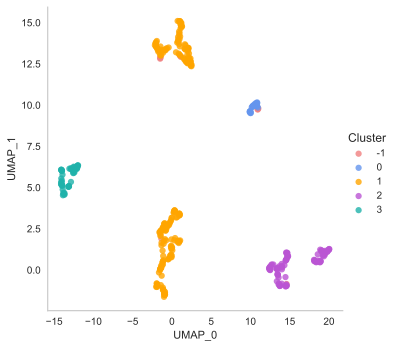

In [61]:
cluster_list_dbscan,cluster_counts_dbscan=clustering.DBSCAN(1.5,15)

In [62]:
FDC_emb_high['Cluster'] = cluster_list_dbscan

In [63]:
#removing noise indices from the embeddings
non_noise_indices= np.where(np.array(cluster_list_dbscan)!=-1)
FDC_emb_high= FDC_emb_high.iloc[non_noise_indices]
FDC_emb_low= FDC_emb_low.iloc[non_noise_indices]
cluster_list_dbscan= np.array(cluster_list_dbscan)[non_noise_indices]


In [64]:
silhouette_score(FDC_emb_high, cluster_list_dbscan, metric='euclidean')

0.4065767962448195

In [65]:
dunn_index(cluster_wise_df(FDC_emb_high,cluster_list_dbscan))

0.5071731733931554